In [3]:
from dotenv import load_dotenv
import sys, os 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../../src")))
load_dotenv()

%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from utils.custom_message_text import show_prompt
from core.prompts.PromptManager import PromptManager
from core.prompts.PromptType import PromptType

prompt_manager = PromptManager()
show_prompt(
    prompt_manager.get_prompt(
        PromptType.SYSTEM_SUPERVISOR,
        messages=[],
        date="",
        max_concurrent_research_units=3,
        max_researcher_iterations=3,
    )
)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  당신은 **연구 감독자(Research Supervisor)** 입니다.                                                            │
│  당신의 역할은 "ConductResearch" 도구를 사용하여 전체 연구를 총괄하고 관리하는 것입니다.                        │
│  참고로, 오늘 날짜는  입니다.                                                                                   │
│                                                                                                                 │
│  <할일>                                                                                                         │
│  당신의 주요 임무는 사용자가 제시한 **전체 연구 질문(Research Question)** 을 기반으로                           │
│  "ConductResearch" 도구를 호출하여 실제 연구를 수행하는 것입니다.                                               │
│                                                                                                                 │
│  연구 결과에 충분히 만족한다고 판단되면                                                                         │
│  "ResearchComplete" 도구를 호출하여 연구가 완료되었음을 명시해야 합니다.                                        │
│  </할일>                                                                                                        │
│                                                                                                                 │
│  <사용 가능한 도구>                                                                                             │
│  당신은 다음 세 가지 주요 도구를 사용할 수 있습니다:                                                            │
│                                                                                                                 │
│  1. **ConductResearch**: 개별 하위 에이전트에게 연구를 위힘하는 도구                                            │
│  2. **ResearchComplete**: 연구가 완료되었음을 알리는 도구                                                       │
│  3. **think_tool**: 연구 과정 중 사고(반성) 및 전략적 계획을 수행하는 도구                                      │
│                                                                                                                 │
│  **중요 지침**                                                                                                  │
│  - ConductResearch 도구를 호출하기 **전에** 항상 'think_tool'을 사용하여 접근 방식을 계획하세요.                │
│  - 각 ConductResearch 호출이 끝난 **후에도** 반드시 'think_tool'을 사용해 진행 상황을 평가하세요.               │
│                                                                                                                 │
│  **병렬 연구(Parallel Research)**                                                                               │
│  연구 주제 내에서 서로 독립적인 하위 주제를 여러 개 식별했다면,                                                 │
│  하나의 응답에서 여러개의 ConductResearch 도구를 **동시에 호출**하여 병렬로 연구를 진행할 수 있습니다.          │
│  이는 다면적 비교나 종합적 탐구가 필요한 경우 효율적입니다.                                                     │
│  단, 한 번에 최대 3 개의 병렬 에이전트까지만 허용됩니다.                                                        │
│  </사용 가능한 도구>                                                                                            │
│                                                                                                                 │
│  <작업 지침>                                                                                                    │
│  제한된 시간과 자원을 가진 연구 매니저처럼 사고하세요.                                                          │
│  다음 단계를 따르십시오:                                                                                        │
│                                                                                                                 │
│  1. **질문을 신중히 읽기** - 사용자가 진짜로 알고자 하는 구체적인 정보는 무엇입니까?                            │
│  2. **연구 위임 결정하기** - 질문을 분석하여, 어떤 방향으로 연구를 위임할지 판단하세요.                         │
│      독립적인 하위 주제가 여러개 있습니까? 병렬 연구가 가능한가요?                                              │
│  3

In [2]:
# %%writefile supervisor_state.py 

import operator 
from typing_extensions import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool 
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field

class SupervisorState(TypedDict):
    supervisor_messages:Annotated[Sequence[BaseMessage],add_messages]
    research_brief:str 
    notes:Annotated[list[str],operator.add] = [] 
    research_iterations:int = 0 
    raw_notes:Annotated[list[str],operator.add] = [] 
    
@tool
class ConductResearch(BaseModel):
    """이 도구는 연구를 세분화하여, 특정 주제에 더 잘맞는 하위 에이전트에게 연구 작업을 위힘하도록 돕습니다."""
    research_topic:str = Field(
        description="연구할 주제입니다. 하나의 단일 주제여야 하며, 최소한 하는 한 단락이상으로 구체적으로 자세히 설명되어야 합니다."
    )    
    
@tool
class ResearchComplete(BaseModel):
    """이제 연구가 완료되었으니, 다음 단계(예: 요약, 보고서 생성등)로 넘겨주세요"""
    pass

In [3]:
%%writefile supervisor_agent.py
from langchain_core.messages import (
    BaseMessage,
    filter_messages,
    SystemMessage,
    ToolMessage,
)
from langchain.chat_models import init_chat_model
from tools import think_tool
from agent.supervisor.supervisor_state import (
    SupervisorState,
    ConductResearch,
    ResearchComplete,
)
from langgraph.types import Command
from typing_extensions import Literal
from utils.helper import get_today_str
from core.prompts.PromptManager import PromptManager
from core.prompts.PromptType import PromptType


def get_notes_from_tool_calls(messages: list[BaseMessage]) -> list[str]:
    """감독자(supervisor)의 메시지 기록에서 ToolMessage 객체에 포함된 연구 노트를 추출합니다.

    이 함수는 하위 에이전트(sub-agent)가 반환한 압축된 연구 결과를 가져옵니다.

    감독자가 ConductReasearch 툴 호출을 통해 연구를 하위 에이전트에게 위임하면,
    각 하위 에이전트는 자신이 요약한 연구 결과를 ToolMessage의 content로 반환합니다.

    이 함수는 그러한 ToolMessage의 내용을 모두 추출하여,
    최종 연구 노트 리스트로 정리합니다.
    """

    return [
        tool_msg.content for tool_msg in filter_messages(messages, include_types="tool")
    ]


supervisor_tools = [ConductResearch, ResearchComplete, think_tool]

try:
    import nest_asyncio

    try:
        from IPython import get_ipython

        if get_ipython() is not None:
            nest_asyncio.apply()
    except ImportError:
        pass
except ImportError:
    pass


supervisor_tools = [ConductResearch, ResearchComplete, think_tool]
supervisor_model = init_chat_model(model="gpt-5.1", model_provider="openai")

supervisor_model_with_tools = supervisor_model.bind_tools(supervisor_tools)

max_researcher_iterations = 5
max_concurrent_researchers = 3

prompt_manager = PromptManager()


async def supervisor(state: SupervisorState) -> Command[Literal["supervisor_tools"]]:
    supervisor_prompt = prompt_manager.get_prompt(
        PromptType.SYSTEM_SUPERVISOR,
        date=get_today_str(),
        max_researcher_iterations=max_researcher_iterations,
        max_concurrent_research_units=max_concurrent_researchers,
    )

    system_message = SystemMessage(content=supervisor_prompt)
    messages = [system_message] + state.get("supervisor_messages")
    response = await supervisor_model_with_tools.ainvoke(messages)

    return Command(
        goto="supervisor_tools",
        update={
            "supervisor_messages": [response],
            "research_iterations": state.get("research_iterations", 0) + 1,
        },
    )


from agent.research.research_agent import graph as research_graph
from langchain_core.messages import HumanMessage
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from typing_extensions import Literal
import asyncio


async def supervisor_tools(
    state: SupervisorState,
) -> Command[Literal["supervisor", "__end__"]]:
    supervisor_messages = state.get("supervisor_messages", [])
    research_iterations = state.get("research_iterations", 0)

    last_message = supervisor_messages[-1]

    tool_messages = []
    all_raw_notes = []
    next_step = "supervisor"
    should_end = False

    exit_iterations = research_iterations >= max_researcher_iterations
    no_tool_calls = not last_message.tool_calls
    research_complete = any(
        tool_call["name"] == "ResearchComplete" for tool_call in last_message.tool_calls
    )

    if exit_iterations or no_tool_calls or research_complete:
        should_end = True
        next_step = END
    else:
        try:
            think_tool_calls = [
                tool_call
                for tool_call in last_message.tool_calls
                if tool_call["name"] == "think_tool"
            ]

            conduct_research_calls = [
                tool_call
                for tool_call in last_message.tool_calls
                if tool_call["name"] == "ConductResearch"
            ]

            for tool_call in think_tool_calls:
                observation = think_tool.invoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=observation,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"],
                    )
                )

            if conduct_research_calls:
                coros = [
                    research_graph.ainvoke(
                        {
                            "researcher_messages": [
                                HumanMessage(
                                    content=tool_call["args"]["research_topic"]
                                )
                            ],
                            "research_topic": tool_call["args"]["research_topic"],
                        }
                    )
                    for tool_call in conduct_research_calls
                ]

                conduct_research_calls_results = await asyncio.gather(*coros)

                research_tool_messages = [
                    ToolMessage(
                        content=result.get(
                            "compressed_research", "연구 보고서를 합성하는 중 오류 발생"
                        ),
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"],
                    )
                    for result, tool_call in zip(
                        conduct_research_calls_results, conduct_research_calls
                    )
                ]
                tool_messages.extend(research_tool_messages)
                all_raw_notes = [
                    "\n".join(result.get("raw_notes", []))
                    for result in conduct_research_calls_results
                ]
        except Exception as e:
            print(f"Error in supervisor tools: {e}")
            should_end = True
            next_step = END

        if should_end:
            return Command(
                goto=next_step,
                update={
                    "notes": get_notes_from_tool_calls(supervisor_messages),
                    "research_brief": state.get("research_brief", ""),
                },
            )
        else:
            return Command(
                goto=next_step,
                update={
                    "supervisor_messages": tool_messages,
                    "raw_notes": all_raw_notes,
                },
            )


graph_builder = StateGraph(SupervisorState)
graph_builder.add_node("supervisor", supervisor)
graph_builder.add_node("supervisor_tools", supervisor_tools)
graph_builder.add_edge(START, "supervisor")
graph = graph_builder.compile()

Overwriting supervisor_agent.py


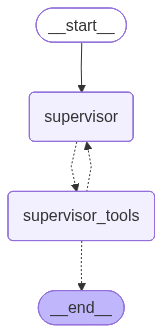

In [17]:
graph